Revisiting the Crime Clustering notebook to better divide the clusters into set sizes.


This model was to was created to illustrate an understanding of capacitated Kmeans clustering algorithms and use them in a hypothetical situation using real-world data.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import geopandas as gpd
import contextily as ctx

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
file_paths = glob.glob('Metropolitan/*.csv')
seperate_dfs = [pd.read_csv(file) for file in file_paths]
df = pd.concat(seperate_dfs, ignore_index=True)
df.head()

Crime ID    Month  \
0  a5a2ab72258bfb2e808347707bcc312470d031825e0911...  2023-06   
1  16efc0a615f7368d0d34c82d9989a1eb485616f8bc56d3...  2023-06   
2  8400c77980478215c845adbe62aae9b205385268ca8b4a...  2023-06   
3  f087d98aff683f2a8e59de5cf0ae87c876dd77794fd804...  2023-06   
4                                                NaN  2023-06   

                   Reported by                 Falls within  Longitude  \
0  Metropolitan Police Service  Metropolitan Police Service  -0.685028   
1  Metropolitan Police Service  Metropolitan Police Service  -0.686514   
2  Metropolitan Police Service  Metropolitan Police Service   0.876053   
3  Metropolitan Police Service  Metropolitan Police Service   0.870748   
4  Metropolitan Police Service  Metropolitan Police Service   0.140194   

    Latitude                   Location  LSOA code                  LSOA name  \
0  50.780596       On or near Park Road  E01031437                  Arun 017E   
1  50.780694    On or near Stocker Road  E01031437                  Arun 017E   
2  51.171725  On or near Hereford Close  E01032810               Ashford 001F   
3  51.148056     On or near Bank Street  E01034986               Ashford 005G   
4  51.582356     On or near Hatch Grove  E01000027  Barking and Dagenham 001A   

                     Crime type  \
0  Violence and sexual offences   
1  Violence and sexual offences   
2  Violence and sexual offences   
3  Violence and sexual offences   
4         Anti-social behaviour   

                           Last outcome category  Context  
0                      Status update unavailable      NaN  
1                      Status update unavailable      NaN  
2  Investigation complete; no suspect identified      NaN  
3                      Status update unavailable      NaN  
4                                            NaN      NaN

In [3]:
crimes = df["Crime type"].unique()

#################################################################################
crime_index = 13 #Change the number here to change the crime being looked at 0-13
#################################################################################

print(f"Searching for: {crimes[crime_index]}")
df_filtered = df[df["Crime type"] == crimes[crime_index]] 
print(f"Cases found: {df_filtered.shape[0]}")

Searching for: Bicycle theft
Cases found: 11300


In [4]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned_lat = remove_outliers(df_filtered, 'Latitude')
df_cleaned = remove_outliers(df_cleaned_lat, 'Longitude')

print(df_filtered.shape)
print(df_cleaned.shape)

(11300, 12)
(10566, 12)


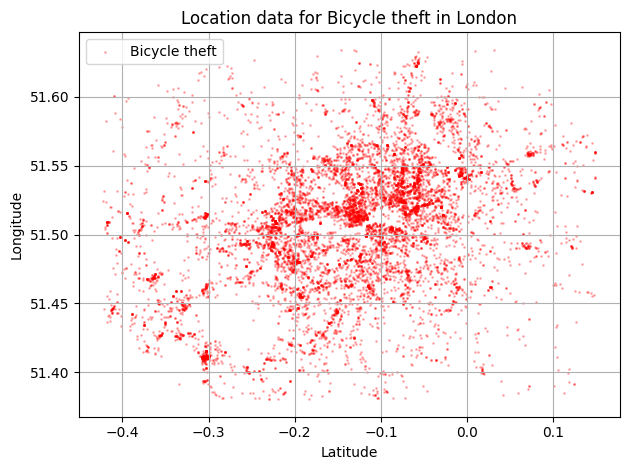

In [5]:
plt.title(f"Location data for {crimes[crime_index]} in London")
plt.scatter(df_cleaned["Longitude"],df_cleaned["Latitude"], s=1, alpha=0.25, label=crimes[crime_index], color="red")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [6]:
X = df_cleaned[["Longitude","Latitude"]].values

# All code from here on in is new

In [7]:
# Randomly place the starting centroids
def initialize_centroids(X, k):
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]

# Assign the datapoints to the closest centroid
def assign_clusters(X, centroids, capacities):
    clusters = {i: [] for i in range(len(centroids))}
    cluster_labels = np.full(X.shape[0], -1)  # To store the cluster assignment of each point
    for i, point in enumerate(X):
        distances = np.linalg.norm(point - centroids, axis=1)
        sorted_indices = np.argsort(distances)
        for idx in sorted_indices:
            if len(clusters[idx]) < capacities[idx]:
                clusters[idx].append(point)
                cluster_labels[i] = idx  # Assign point to cluster idx
                break
    return clusters, cluster_labels

# Update the centroids
def update_centroids(clusters):
    centroids = []
    for idx in clusters:
        if clusters[idx]:
            centroids.append(np.mean(clusters[idx], axis=0))
        else:
            centroids.append(np.zeros_like(clusters[0][0]))
    return np.array(centroids)

# Dont allow more than a set amount of points to be assigned any one centroid
def capacitated_kmeans(X, k, capacities, max_iters=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        clusters, cluster_labels = assign_clusters(X, centroids, capacities)
        new_centroids = update_centroids(clusters)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, clusters, cluster_labels

# Define the number of clusters and their capacities

In [9]:
#How many bikes can one storage space hold

######################
storage_size = 500  #Change this value to alter the models outputs
######################

#How many storage spaces are needed based upon storage size
k = int(X.shape[0]/storage_size) 
capacities = [storage_size] * k

# Run the model
centroids, clusters, cluster_labels = capacitated_kmeans(X, k, capacities,100)

A list of colours for the graph to plot the clusters in.

In [10]:
colors = ['red', 'green', 'blue', 'yellow', 'cyan', "lightgreen", "lightblue", "pink","magenta", "seagreen", "brown", "orange", "crimson", "orchid", "teal", "gold", "darkred", "blueviolet", "royalblue", "lime", "olive"]

# Plot the graph with no clusters

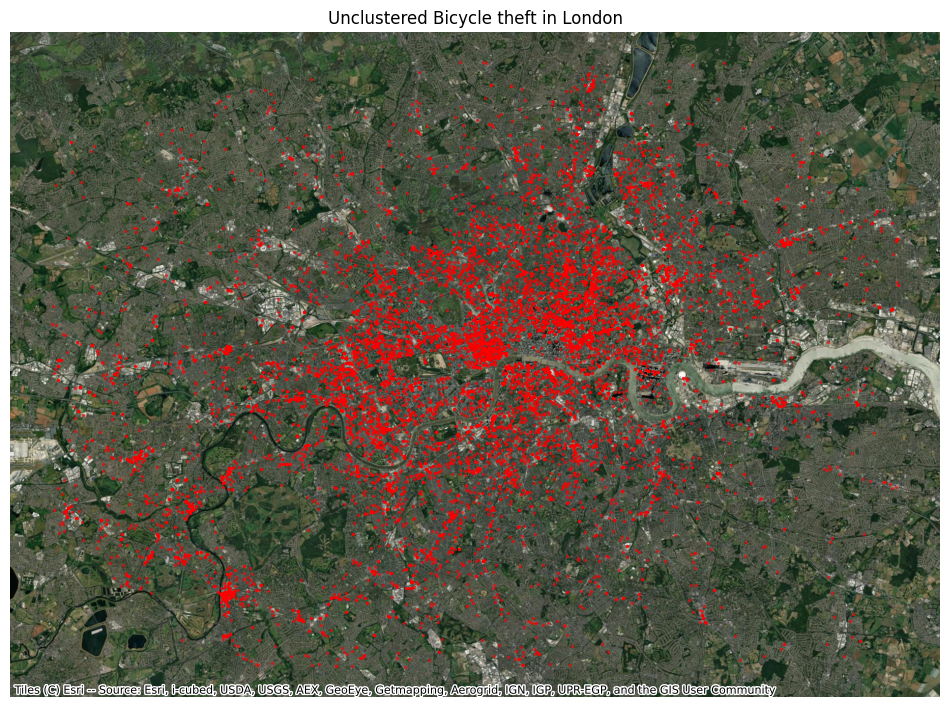

In [27]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_cleaned, geometry=gpd.points_from_xy(df_cleaned.Longitude, df_cleaned.Latitude))
gdf.crs = 'EPSG:4326'

# Convert to Web Mercator (EPSG:3857) for contextily
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, markersize=2, color='red', alpha=0.5)

# Add basemap (satellite imagery)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=12)

plt.title(f"Unclustered {crimes[crime_index]} in London")
plt.axis("off")
plt.show()


# Plot the graph with the clusters

C:\Users\Max\AppData\Local\Temp\ipykernel_768\2902743444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = cluster_labels


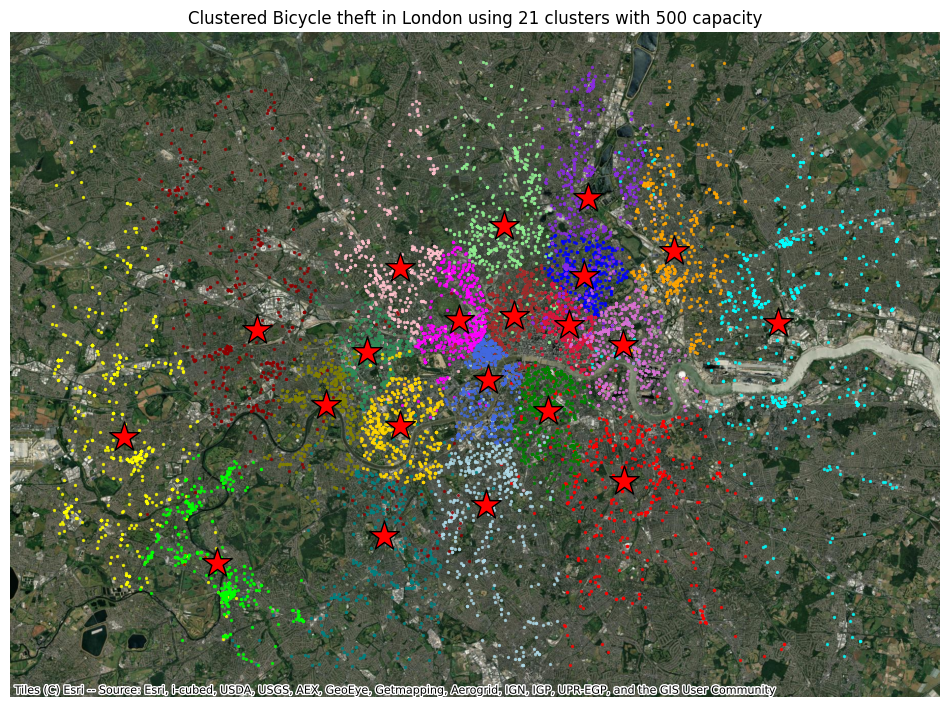

In [26]:
# Extract coordinates as a NumPy array
X = df_cleaned[['Latitude', 'Longitude']].to_numpy()

# Add cluster labels to DataFrame
df_cleaned['cluster'] = cluster_labels

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df_cleaned, geometry=gpd.points_from_xy(df_cleaned.Longitude, df_cleaned.Latitude))
gdf.crs = 'EPSG:4326'

# Convert to Web Mercator (EPSG:3857) for contextily
gdf = gdf.to_crs(epsg=3857)

# Convert centroids to GeoDataFrame
centroids_gdf = gpd.GeoDataFrame(centroids, columns=['latitude', 'longitude'], 
                                 geometry=gpd.points_from_xy(centroids[:, 1], centroids[:, 0]))
centroids_gdf.crs = 'EPSG:4326'
centroids_gdf = centroids_gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each cluster with a different color

for idx in range(k):
    cluster_gdf = gdf[gdf['cluster'] == idx]
    cluster_gdf.plot(ax=ax, markersize=2, color=colors[idx], label=f'Cluster {idx}', alpha=0.75)

# Plot centroids
centroids_gdf.plot(ax=ax, color='red', edgecolor="black", marker='*', markersize=500, label='Centroids')

# Add basemap (satellite imagery)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=12)

#plt.legend()
plt.axis("off")
plt.title(f"Clustered {crimes[crime_index]} in London using {k} clusters with {storage_size} capacity")
plt.show()
